In [ ]:
pip install -q tfds-nightly tensorflow matplotlib

     |████████████████████████████████| 4.0 MB 5.0 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import PIL
from PIL import Image

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

class MiniVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# first CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# second CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [ ]:
model = MiniVGGNet.build(width=125, height=125, depth=3, classes=3)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 125, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 125, 125, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 125, 125, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 125, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0

In [ ]:
datasets, info = tfds.load('beans', with_info=True, as_supervised=True)
beans_train, beans_test = datasets['train'], datasets['test']

print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling beans-train.tfrecord...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling beans-validation.tfrecord...:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling beans-test.tfrecord...:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
    by experts from the National Crops Resources Research Institute (NaCRRI) in
    Uganda and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_path='/root/tensorflow_datasets/beans/0.1.0',
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=Fal

In [ ]:
%%capture
!pip install wandb

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import matplotlib

# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
import wandb
from wandb.keras import WandbCallback

def augmentation(image, label):
  image = tf.image.stateless_random_flip_left_right(image, seed=(2,3))
  image = tf.image.stateless_random_flip_up_down(image, seed=(2,3))
  image = tf.image.rot90(image)
  return image, label

def resize(image, label):
    return tf.image.resize(image, (125,125)), label

beans_train = beans_train.map(augmentation)
beans_test = beans_test.map(augmentation)

beans_train = beans_train.map(resize)
beans_test = beans_test.map(resize)

train_x = list(map(lambda x: x[0], beans_train))
train_y = list(map(lambda x: x[1], beans_train))

test_x = list(map(lambda x: x[0], beans_test))
test_y = list(map(lambda x: x[1], beans_test))

train_x = np.array(train_x) 
train_y = np.array(train_y)

test_x = np.array(test_x) 
test_y = np.array(test_y)

train_x = train_x.astype("float") / 255.0
test_x = test_x.astype("float") / 255.0

lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.transform(test_y)

labelNames = ["angular_leaf_spot", "bean_rust", "healthy"]

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(1034, 125, 125, 3)
(128, 125, 125, 3)
(1034, 3)
(128, 3)


In [ ]:
# Set an experiment name to group training and evaluation
experiment_name = wandb.util.generate_id()

# setup wandb
wandb.init(project="beans2_VGG", 
           group=experiment_name,
           config={
               "epoch": 20,
               "batch_size": 32,
           })
config = wandb.config

epoch,6
loss,0.37715
accuracy,0.87814
val_loss,1.29407
val_accuracy,0.67188
_runtime,785
_timestamp,1631482312
_step,6
best_val_loss,1.29407
best_epoch,6


epoch,▁▂▃▅▆▇█
loss,█▄▄▃▂▁▁
accuracy,▁▄▅▅▇▇█
val_loss,█▂▁▁▁▁▁
val_accuracy,▁▄▇▄▇▆█
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


In [ ]:
%%wandb

# initialize the optimizer and model
print("[INFO] compiling model...")

# An decay parameter was used. This argument is used to slowly reduce the learning rate over time.
# Rate Schedulers, decaying the learning rate is helpful in reducing overfitting
# and obtaining higher classification accuracy – the smaller the learning rate is, 
# the smaller the weight updates will be. A common setting for decay is to divide
# the initial learning rate by the total number of epochs – in this case, 
# we’ll be training our network for a total of 40 epochs with an initial learning rate of 0.01,
# therefore decay = 0.01 / 40.

opt = SGD(learning_rate=0.01, decay=0.01/20, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=125, height=125, depth=3, classes=3)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(train_x, train_y, validation_data=(test_x, test_y),
              batch_size=config.batch_size, 
              epochs=config.epoch,
              verbose=1,
              callbacks=[WandbCallback()])
wandb.finish()

[INFO] compiling model...
[INFO] training network...
Epoch 1/20
33/33 [==============================] - 104s 3s/step - loss: 1.3256 - accuracy: 0.5938 - val_loss: 7.6012 - val_accuracy: 0.3281
Epoch 2/20
33/33 [==============================] - 104s 3s/step - loss: 0.9467 - accuracy: 0.6741 - val_loss: 5.3790 - val_accuracy: 0.3203
Epoch 3/20
33/33 [==============================] - 103s 3s/step - loss: 0.8665 - accuracy: 0.7205 - val_loss: 1.4565 - val_accuracy: 0.5625
Epoch 4/20
33/33 [==============================] - 102s 3s/step - loss: 0.6811 - accuracy: 0.7669 - val_loss: 2.0983 - val_accuracy: 0.4297
Epoch 5/20
33/33 [==============================] - 107s 3s/step - loss: 0.6471 - accuracy: 0.7901 - val_loss: 1.9469 - val_accuracy: 0.6094
Epoch 6/20
33/33 [==============================] - 103s 3s/step - loss: 0.4984 - accuracy: 0.8230 - val_loss: 2.0064 - val_accuracy: 0.5781
Epoch 7/20
33/33 [==============================] - 103s 3s/step - loss: 0.4713 - accuracy: 0.8598 - 

epoch,19
loss,0.0864
accuracy,0.97389
val_loss,1.07915
val_accuracy,0.78906
_runtime,2077
_timestamp,1631484429
_step,19
best_val_loss,0.71913
best_epoch,10


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▃▃▂▂▃▃▂▂▁▁▁▁▁▁▁
accuracy,▁▂▃▄▅▅▆▇▇▆▆▇▇██▇████
val_loss,█▆▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▂▁
val_accuracy,▁▁▄▂▅▅▆▅▅▄▇▇▇▇▇▇█▇▆▇
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


In [ ]:
%%capture
# Install dependencies
!pip install scikit-plot -qqq

_runtime,13
_timestamp,1631484629
_step,1
f1,0.78906


_runtime,▁█
_timestamp,▁█
_step,▁█
f1,▁


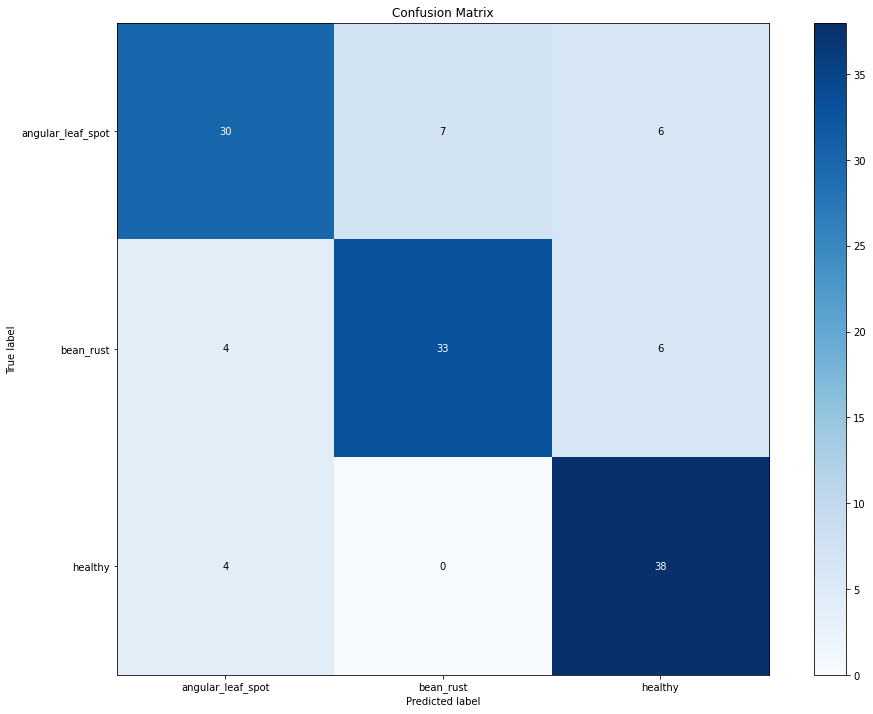

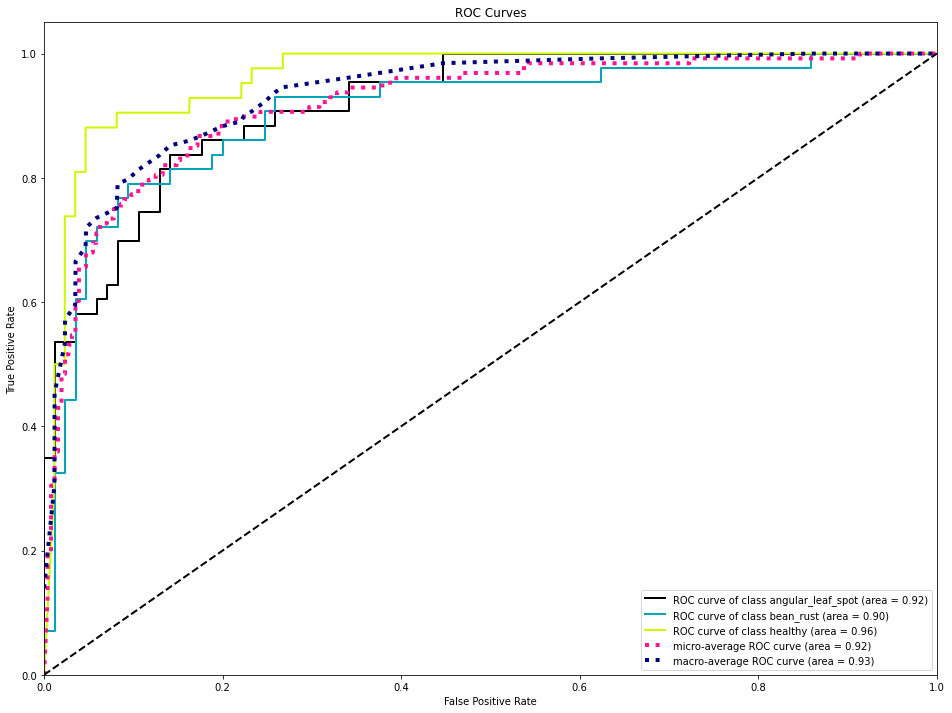

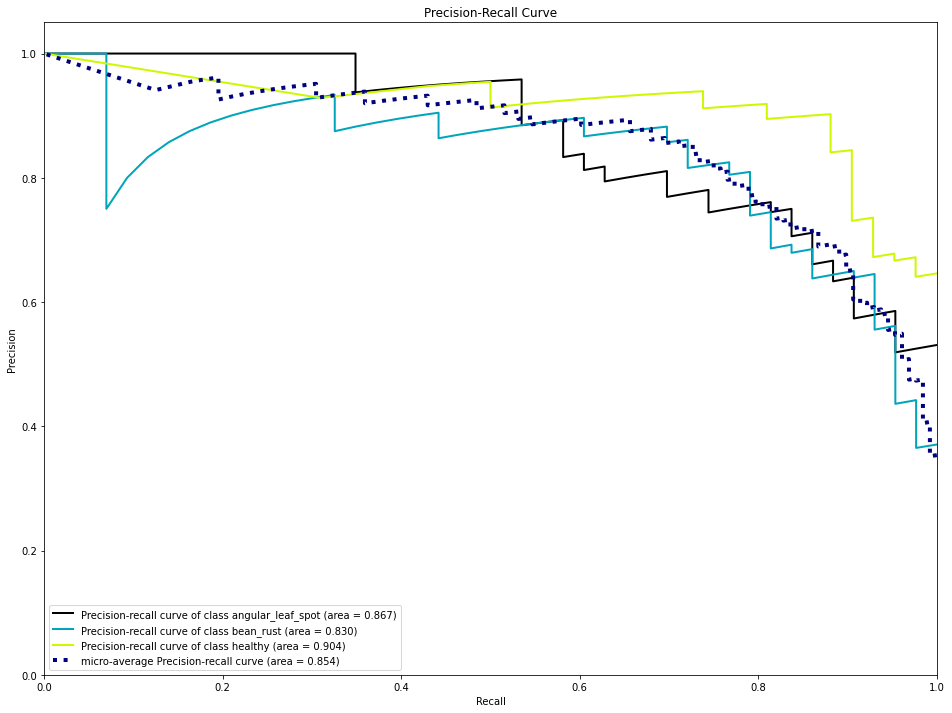

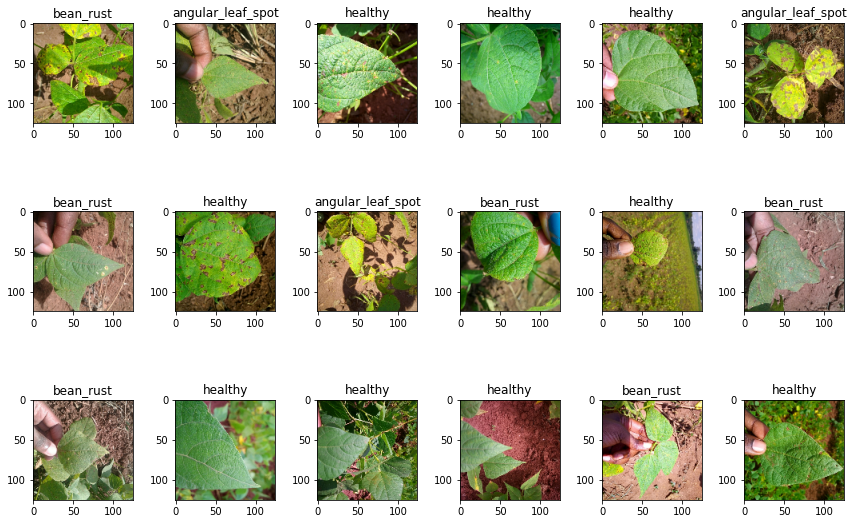

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import tensorflow as tf
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall

wandb.init(project="beans2_VGG", group=experiment_name)

# Class proportions
train_y_labels = [labelNames[i] for i in np.argmax(train_y, axis=1)]
test_y_labels = [labelNames[i] for i in np.argmax(test_y, axis=1)]
wandb.log({'Class Proportions': wandb.sklearn.plot_class_proportions(train_y_labels,
                                                                     test_y_labels,
                                                                     labelNames)},
           commit=False) # Hold on, more incoming!

# Log F1 Score
test_y_pred = np.asarray(model.predict(test_x))
test_y_pred_class = np.argmax(test_y_pred, axis=1)
f1 = f1_score(np.argmax(test_y, axis=1), test_y_pred_class, average='micro')
wandb.log({"f1": f1}, commit=False)

#test_y_labels = [labelNames[i] for i in np.argmax(test_y, axis=1)]
test_y_pred_labels = [labelNames[i] for i in test_y_pred_class]


# Log Confusion Matrix
fig, ax = plt.subplots(figsize=(16, 12))
plot_confusion_matrix(test_y_labels, test_y_pred_labels, ax=ax)
wandb.log({"confusion_matrix": wandb.Image(fig)}, commit=False)

# Log ROC Curve
fig, ax = plt.subplots(figsize=(16, 12))
plot_roc(test_y_labels, test_y_pred, ax=ax)
wandb.log({"plot_roc": wandb.Image(fig)},commit=False)  # Now we've logged everything for this step

# Precision vs Recall
fig, ax = plt.subplots(figsize=(16, 12))
plot_precision_recall(test_y_labels, test_y_pred, ax=ax)
wandb.log({"plot_precision_recall": wandb.Image(fig)},commit=False)  # Now we've logged everything for this step

# Class Scores
class_score_data = []
for test, pred in zip(test_y_labels, test_y_pred):
    class_score_data.append([test, pred])

wandb.log({"class_scores": wandb.Table(data=class_score_data,
                                           columns=["test", "pred"])}, commit=False)

# 
# Visualize Predictions
# 
# visualize 18 images
def show_image(train_image, label, index):
    plt.subplot(3, 6, index+1)
    plt.imshow(tf.squeeze(train_image), cmap=plt.cm.gray)
    plt.title(label)
    plt.grid(b=False)

# predictions
predictions = model.predict(test_x)
results = np.argmax(predictions, axis = 1)

# visualize the first 18 test results
plt.figure(figsize=(12, 8))
for index in range(18):
    label = results[index]
    image_pixels = test_x[index,:,:,:]
    show_image(image_pixels, labelNames[label], index)
plt.tight_layout()

wandb.log({"Predictions": plt}, commit=True)

wandb.finish()

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=32)
print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
                   precision    recall  f1-score   support

angular_leaf_spot       0.79      0.70      0.74        43
        bean_rust       0.82      0.77      0.80        43
          healthy       0.76      0.90      0.83        42

         accuracy                           0.79       128
        macro avg       0.79      0.79      0.79       128
     weighted avg       0.79      0.79      0.79       128

